# A real world example - Iris Classification

Here, we will learn how to implement variational quantum classifiers, that can be trained from labelled data of iris to classify new data samples.

Work inspired from [Farhi and Neven (2018)](https://arxiv.org/abs/1802.06002) and [Schuld et al. (2018)](https://arxiv.org/abs/1804.00633)

This tutorial is taken from the combination of Pennylanes handbook and [a quantum neural network beginner manual](https://medium.com/@anjanakrishnan3100/qnn-a-beginners-overview-and-breakdown-of-code-d4f62a0947f2)


# The Iris Data Set

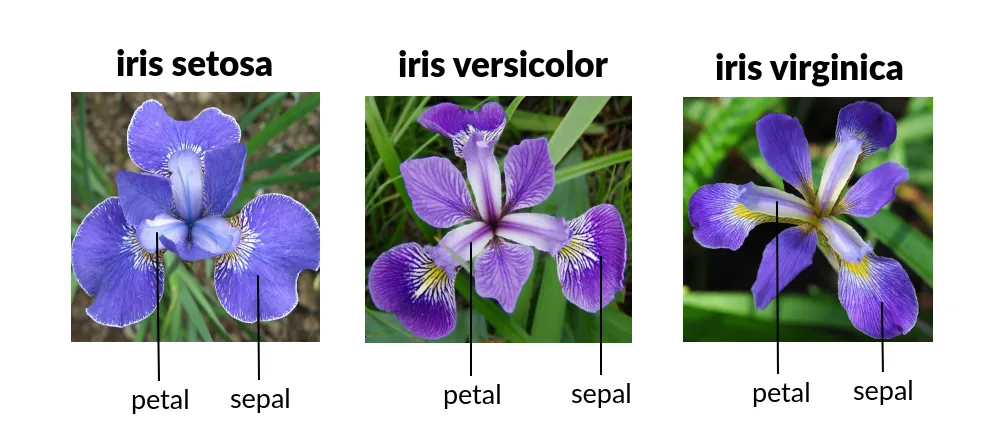

The Iris dataset serves as an excellent starting point for understanding Quantum Machine Learning (QML). It is a widely-used dataset in the machine learning community, which **contains 150 samples and designs to classify iris flowers into three species based on four key features: sepal length, sepal width, petal length, and petal width**. Here, the objective is to develop an algorithm that can automatically classify iris flowers into two species based on these measurements. The dataset is typically divided into two sets: the training set, where manipulations are performed, and the test set, where the model’s performance is evaluated.

In [ ]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator  # Use AerSimulator instead of Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import qiskit
import copy

## Data

We then load the Iris data set and take a brief look at one sample of feature set (X) and label set (y), from now on, take the first two class

In [ ]:
iris = datasets.load_iris()
x = iris.data[:100]
y = iris.target[:100]
x_train, x_test, y_train, y_test =  model_selection.train_test_split(x,y,test_size=0.33, random_state=42)
print('One sample of features X =', x_train[0])
print('One sample of classification label y =', y_train[0])

In [ ]:
print(iris.DESCR)

There are a few interesting observations we can find from this dataset description:

There are 150 samples (instances) in the dataset.

There are four features (attributes) in each sample.

There are three labels (classes) in the dataset.

The dataset is perfectly balanced, as there are the same number of samples (50) in each class.

# Feature Mapping

Feature Mapping is where we translate the classical bits into quantum bits.

For the iris problem, we use angle encoding and thus rotate the qubits using rotating gates.

In [ ]:
# Change data point to different rotation

# N must be equal number of features
N = 4

def feature_map(X,N=4,C=1):

    q = QuantumRegister(N)
    c = ClassicalRegister(C)
    qc = QuantumCircuit(q,c)

    for i,x in enumerate(X):
        qc.rx(x,i)

    return qc,c

# Variational Circuit

The objective is to find the best rotation values. By experimenting with different rotation values and observing the outcomes, the quantum neural network strives to identify the rotation values that lead to the most optimized and accurate predictions.

In [ ]:
def variational_circuit(qc, theta):
    for i in range(N - 1):
        qc.cx(i, i + 1)
    qc.cx(N - 1, 0)
    for i in range(N):
        qc.ry(theta[i], i)
    return qc

# The Quantum Circuit code - operate one sample

In [ ]:
qc,c = feature_map(x_train[5],N=4,C=1)

qc.barrier()

qc = variational_circuit(qc,np.random.rand(N))

qc.barrier()

qc.measure(0,c)

from qiskit import transpile
backend = AerSimulator()
qc_compiled = transpile(qc,backend)
job = backend.run(qc_compiled, shots = 128)
result = job.result()
counts = result.get_counts()
print(counts)

qc.draw('mpl', style='clifford')

Now we make the variational circuit code as a function 'quantum_nn'

In [ ]:
def quantum_nn(X,theta,N=4,C=1,simulator=True):

    qc,c = feature_map(X,N,C)
    qc = variational_circuit(qc,theta)
    qc.measure(0,c)

    shots = 128
    backend = AerSimulator()
    qc_compiled = transpile(qc,backend)
    job = backend.run(qc_compiled, shots = shots)
    result = job.result()
    counts = result.get_counts()

    return (counts['1']/shots)

**Define the loss function**

The loss function plays a pivotal role in quantifying the model’s errors. It calculates a number that represents how far off the guesses are from the correct answers and the goal is to minimize this number— the lower, the better.

In [ ]:
def calc_loss(prediction,target):
    return (prediction-target)**2

**Make a prediction on one sample as a test**

In [ ]:
prediction = quantum_nn(x_train[5],np.random.rand(N))

target = y_train[5]

print('prediction value =', prediction, ', true label =', target)

# **Gradient function**
Once the loss function is computed, the next step is to enhance the model’s predictions. This is where the gradient descent function comes into play. The gradient descent function facilitates a step-by-step adjustment of the predictions, similar to descending the mountain. It guides the model towards making better predictions by iteratively refining its parameters.

In [ ]:
def gradient(X_i,Y_i,theta):
    delta = 0.005
    grad = []
    dtheta = copy.copy(theta)
    for i in range(len(theta)):
        dtheta[i] += delta

        predict1 = quantum_nn(X_i,dtheta)
        predict2 = quantum_nn(X_i,theta)

        # Finite difference
        grad.append( (calc_loss(predict1,Y_i) - calc_loss(predict2,Y_i)) / delta )
    return np.array(grad)

# **Accuracy Calculation**

Evaluating the quantum neural network’s performance is a crucial step. It involves comparing the network’s predictions to the actual labels in the test dataset. This provides a quantitative measure of how well the model is classifying iris flowers into the correct species.

In [ ]:
def accuracy(X,Y,theta):
    counter = 0
    for X_i,Y_i in zip(X,Y):
        prediction = quantum_nn(X_i,theta)

        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
    return (counter/len(Y))

# **Training by Epoch**

**Warning!** The following computation will take long time due to not optimizing using built-in functions in specific developed package, like qiskit_quantum-machine-learning

To refine the quantum neural network’s performance, we employ a training process organized into epochs. Each epoch represents a complete pass through the training data. During each epoch, the network’s parameters, including the rotation values, are updated to improve predictive accuracy. Think of epochs as iterations or practice sessions in which the model gradually learns from previous data and makes incremental improvements over time.

In [ ]:
import time
start = time.time()

epoch = 30
eta = 0.005
loss_list = []
theta = np.ones(N)

print(f'Epoch \t Loss \t Accuracy')
for i in range(epoch):
    loss_tmp = []
    for X_i,Y_i in zip(x_train,y_train):
        prediction = quantum_nn(X_i,theta)
        loss_tmp.append(calc_loss(prediction,Y_i))

        # Update theta
        theta = theta - eta*gradient(X_i,Y_i,theta)

    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(x_train,y_train,theta)

    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


In [ ]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()